## MIPS
noninteracting particles with motility restricted by density

In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import os
import matplotlib.patches as patches

In [2]:
# Jupyter notebook magic for matplotlib
%matplotlib notebook

In [35]:
class MIPS:
    def __init__(self, N, eta, r,L):
        # Initialize simulation
        self.L = L  # length of the square 2D region to be simulated
        self.halfL = self.L / 2  # half of length (used later for PBCs)
        self.N = N  # number of particles in the 2D region
        self.rho = N/self.L**2  # density of particles in the simulation
        self.eta = eta  # noise in the system
        self.r = r  # interaction radius
        self.rsq = self.r * self.r  # square of interaction radius
        self.dt = 0.1  # time step
        self.vinit = 20
        self.v = self.vinit*np.ones(self.N)  # magnitude of velocity
        self.pos = np.random.rand(self.N, 2) * self.L  # random initial position in 2D region
        self.direction = np.zeros(self.N)     # 0 for moving toward goal, 1 for moving toward home
        self.state = np.zeros(self.N)         # 0 for walker, 1 for bridge
        
        self.theta = (np.random.rand(self.N) * 2 - 1) * np.pi  # random velocity angle [-pi pi]
        self.vel = np.zeros((self.N, 2))  # initialize velocity array
        self.vel[:, 0] = self.v * np.cos(self.theta)  # velocity along x
        self.vel[:, 1] = self.v * np.sin(self.theta)  # velocity along y
        self.tt = 5000  # total number of time steps
        self.rparts = np.eye(N, dtype=np.bool)  # matrix representing particles within distance r
        
        self.home = (2.5,10)
        self.goal = (17.5,10)

    def main(self):
    
        axrange = [-5, self.L+5, -5, self.L+5]
        
        #Setup plot for updated positions
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        fig1.show()
        fig1.tight_layout()
        fig1.canvas.draw()
        for nn in range(self.tt):
            ax1.clear()
            x = [7.5,12.5,11,9]
            y = [0,0,20,20]
            ax1.add_patch(patches.Polygon(xy=list(zip(x,y)),edgecolor='blue',facecolor='blue', fill=True,zorder=0, alpha=0.1)) # obstacle
            ax1.add_patch(patches.Rectangle((self.home[0]-self.r/2,self.home[1]-self.r/2),self.r,self.r ,edgecolor='green',facecolor='green', fill=True,zorder=0, alpha=0.3))   # home
            ax1.add_patch(patches.Rectangle((self.goal[0]-self.r/2,self.goal[1]-self.r/2),self.r,self.r ,edgecolor='red',facecolor='red', fill=True,zorder=0, alpha=0.3))       # object

            ax1.quiver(self.pos[:, 0], self.pos[:, 1], self.vel[:, 0], self.vel[:, 1])
            
            ax1.scatter(self.pos[self.state==0][:, 0], self.pos[self.state==0][:, 1],s=100,alpha=0.5,c='k')    # walker
            ax1.scatter(self.pos[self.state==1][:, 0], self.pos[self.state==1][:, 1],s=100,alpha=0.5,c='y')    # bridge

            
            
            ax1.axis(axrange)
            ax1.set_aspect('equal', 'box')
            fig1.canvas.draw()
            fig1.savefig(str(os.getcwd())+'/fig3/'+str(nn)+'.png')
            self.update()

    def update(self):

        # Generate the set of random movements dTheta from [-eta/2, eta/2]
        noise = (np.random.rand(self.N) - 0.5) * self.eta

        # Find particles within distance r
        self.find_particles()
        self.direction[self.rhome]=0
        self.direction[self.rgoal]=1
        
        
        
        orient = np.arctan2(self.goal[1]*(self.direction==0)   +self.home[1]* (self.direction==1)  -self.pos.T[1],self.goal[0]*(self.direction==0)   +self.home[0]* (self.direction==1)  -self.pos.T[0])
        self.theta = orient+(1-0.1*self.dt)*(np.mod((self.theta-orient)+np.pi,2*np.pi)-np.pi)  +noise*self.dt
    
    
        self.v = self.vinit
    
    
#         for i in range(self.N):
#             neighbor = np.sum(self.rparts[i,:])
#             #self.v[i] = self.vinit/(1+0.05*neighbor + 0.001*neighbor**2)
#             self.v[i] = self.vinit/neighbor
        # Updated velocities
        self.vel[:, 0] = self.v * np.cos(self.theta)
        self.vel[:, 1] = self.v * np.sin(self.theta)

        # Updated positions
        self.pos = self.pos + self.vel * self.dt

#         # Applying periodic boundaries
#         self.pos = np.mod(self.pos, self.L)

    def find_particles(self):     # updated using matrix operation

        # Reset rparts matrix
        self.rparts = np.eye(self.N, dtype=np.bool)
        
        x = self.pos[:,0].reshape(1,-1)
        y = self.pos[:,1].reshape(1,-1)
        
        diffx = x-x.T
        diffy = y-y.T
        
        diffxn = -self.halfL + np.mod(diffx+self.halfL,self.L)
        diffyn = -self.halfL + np.mod(diffy+self.halfL,self.L)
        
        diff = diffxn**2+diffyn**2
        
        #self.rparts = 1/(diff/self.r**2+1)
        self.rparts = diff<self.rsq
        
        self.rhome = (self.pos[:,0]-self.home[0]>-self.r/2)*(self.pos[:,0]-self.home[0]<self.r/2)*(self.pos[:,1]-self.home[1]>-self.r/2)*(self.pos[:,1]-self.home[1]<self.r/2)
        self.rgoal = (self.pos[:,0]-self.goal[0]>-self.r/2)*(self.pos[:,0]-self.goal[0]<self.r/2)*(self.pos[:,1]-self.goal[1]>-self.r/2)*(self.pos[:,1]-self.goal[1]<self.r/2)


In [36]:
def start_AM_sim(num_particles=2, noise=0.5, v=1, r=2, L=20):
    v2d = MIPS(num_particles, noise, r,L)
    v2d.vinit = v
    print("Box size =", v2d.L)
    print("Particle density =", v2d.rho)
    v2d.main()

Box size = 20
Particle density = 0.25


<IPython.core.display.Javascript object>


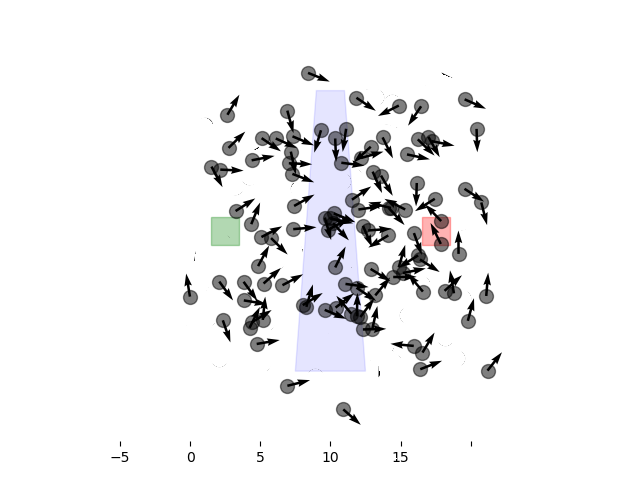

KeyboardInterrupt: 

In [37]:
# Interactive control for entering number of particles
style = {'description_width': 'initial'}    
# num_particles = widgets.IntSlider(description='Number of particles', style=style, 
#                                     min=100, max=1100, step=200, value=2, continuous_update=False)
# # Interactive control for entering noise
# noise = widgets.FloatSlider(description='Noise', style=style, 
#                              min=0.1, max=1, step=0.1, value=0, continuous_update=False)

num_particles = 100
noise = 2
v=0.3
#r=0.5
r=2
L=20

# Creating the interactive controls
# widget_ui = widgets.HBox([num_particles, noise])
# widget_out = widgets.interactive_output(start_AM_sim, 
#                                         {'num_particles': num_particles, 'noise': noise})
# # Display the controls and output
# # display(widget_ui, widget_out)
# display(widget_out)

start_AM_sim(num_particles,noise,v,r,L)

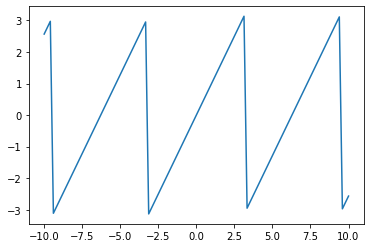

In [29]:
t=np.linspace(-10,10,100)
%matplotlib inline
# print(np.arctan2(np.sin(t),np.cos(t)))
plt.plot(x, np.arctan2(np.sin(t),np.cos(t)))
plt.show()

In [64]:
x = np.zeros((5,2))
(x==0)

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import os
import matplotlib.image as mpimg
path = [f"./fig1/{i}.png" for i in range(1000)]
paths = [ Image.open(i) for i in path]
imageio.mimsave('./test1.gif', paths, fps=300)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import os
import matplotlib.image as mpimg
path = [f"./fig2/{i}.png" for i in range(1000)]
paths = [ Image.open(i) for i in path]
imageio.mimsave('./test2.gif', paths, fps=300)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import os
import matplotlib.image as mpimg
path = [f"./fig3/{i}.png" for i in range(3000)]
paths = [ Image.open(i) for i in path]
imageio.mimsave('./test3.gif', paths, fps=300)